# Minimal Example

In [1]:
import jax
jax.config.update("jax_enable_x64", True) # unfortunately we currently require double precision
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib widget

/home/ohahn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
## these are the main modules for background evolution and perturbation evolution
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, get_power

In [3]:
# @jax.jit
def compute_matter_power( Omegam=0.3099 ):

  ## Set the Cosmological Parameters
  # insert parameters into a dictionary
  param = {}
  # OmegaDE is inferred since flatness is assumed currently
  param['Omegam']  = Omegam            # Total matter density parameter
  param['Omegab']  = 0.0488911         # Baryon density parameter
  param['w_DE_0']  = -0.99             # Dark energy equation of state parameter today
  param['w_DE_a']  = 0.0               # Dark energy equation of state parameter time derivative
  param['cs2_DE']  = 1.0               # Dark energy sound speed squared
  param['Omegak']  = 0.0
  param['A_s']     = 2.1064e-09        # Scalar amplitude of the primordial power spectrum
  param['n_s']     = 0.96822           # Scalar spectral index
  param['H0']      = 67.742            # Hubble constant today in units of 100 km/s/Mpc
  param['Tcmb']    = 2.7255            # CMB temperature today in K
  param['YHe']     = 0.248             # Helium mass fraction
  param['Neff']    = 2.046             # Effective number of ultrarelativistic neutrinos
                                      # -1 if massive neutrino present
  param['Nmnu']    = 1                 # Number of massive neutrinos (must be 1 currently)
  param['mnu']     = 0.06              # Sum of neutrino masses in eV 
  param['k_p']     = 0.05              # Pivot scale in 1/Mpc

  # modes to sample
  nmodes = 64                 # number of modes to sample
  kmin   = 1e-3               # minimum k in 1/Mpc
  kmax   = 1e+0               # maximum k in 1/Mpc
  aexp   = 1.0                # scale factor at which to evaluate the power spectrum

  ## Compute Background+thermal evolution
  param = evolve_background(param=param, thermo_module='RECFAST')

  # compute perturbation evolution
  aexp_out = jnp.array([aexp])
  y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                    rtol=1e-4, atol=1e-4 )
  
  # turn perturbations into power spectra
  Pkm = get_power( k=kmodes, y=y[:,0,:], idx=4, param=param )

  return Pkm, kmodes

## Compute and plot the matter power spectrum

In [4]:
# might take a minute to compile on first run, 10s on rerun
Omegam_fid = 0.3099
Pkm, kmodes = compute_matter_power( Omegam_fid )

Text(0, 0.5, '$P(k)$')

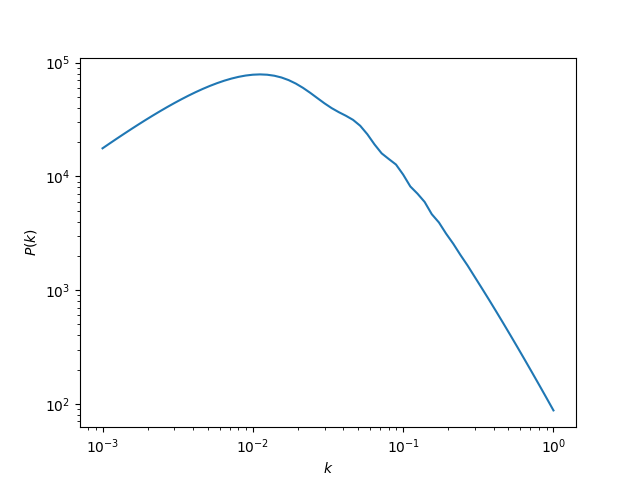

In [5]:
fig, ax = plt.subplots()

ax.plot(kmodes, Pkm, label='delta_m')
ax.loglog()
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

## Compute and plot the derivative of $P_m$ w.r.t. $\Omega_m$

In [6]:
diff_matter_power = jax.jacfwd( compute_matter_power )
dPkm,_ = diff_matter_power( Omegam_fid )

Text(0, 0.5, '$\\partial \\log P(k)/\\partial \\log \\Omega_m$')

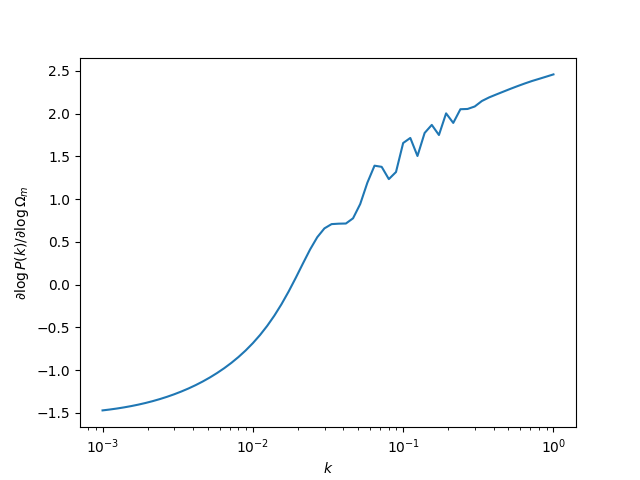

In [7]:
fig, ax = plt.subplots()

ax.semilogx(kmodes, Omegam_fid * dPkm / Pkm, label='delta_m')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\partial \log P(k)/\partial \log \Omega_m$')